In [1]:
import os
import numpy as np
import pandas as pd
import shutil
from read_roi import read_roi_file
import tifffile
import matplotlib.pyplot as plt
import create_mask_for_region
from datetime import datetime
from contour_visualization import *

#import shap
# read heatmap plots
#import Heatmap_plots as hmp
import seaborn as sns
import pickle
import tifffile as tiff

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [2]:
# set figure key
figure_key = 'Figure3'

In [3]:
# set paths
result_paths = r"\\10.159.50.7\analysis2\Ken\LSMS\Opioid"
rootpath = r"G:\My Drive\Opioid_whole_brain_manuscript"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_root_figurepath = os.path.join(rootpath,"figure")
analysis_figurepath = os.path.join(analysis_root_figurepath,figure_key)
for path in [analysis_resultpath,analysis_root_figurepath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)

# load meta info of the files
metadf = pd.read_csv(os.path.join(metapath,"OP_meta.csv"),index_col= False)
# temporary drop of A7 due to missing data
metadf = metadf[metadf.ID != 'A7'].reset_index(drop = True)
# load brain atlas to register
atlas_df = pd.read_csv(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\atlas_info_KimRef_FPbasedLabel_v4.0_brain_with_size_with_curated_with_cleaned_acronyms.csv",index_col = False)
metacolumns = ['id','acronym','parent_acronym','parent_id','structure_order']
contour_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v2.9_contour_map.tif")
# retrieve list of files
fnames =  [f for f in metadf.fname.values if 'DONE' in f]

In [4]:
#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)

# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from adjustText import adjust_text

# Set matplotlib parameters for white text on transparent background
plt.rcParams.update({
    'figure.facecolor': 'none',  # Transparent figure background
    'axes.facecolor': 'none',    # Transparent axes background
    'axes.edgecolor': 'black',   # White axes edge color
    'axes.labelcolor': 'black',  # White axis labels
    'xtick.color': 'black',      # White tick labels
    'ytick.color': 'black',      # White tick labels
    'legend.facecolor': 'none',  # Transparent legend background
    'legend.edgecolor': 'none',  # Transparent legend edgecolor
    'text.color': 'black',       # White text color
    'font.family':'Arial',
    'pdf.fonttype':42,
    'ps.fonttype':42,
   
})
#important for text to be detected when importing saved figures into illustrator


In [6]:
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)

In [7]:
default_depth = 4
# set heatmap variables
vmin= -5
vmax = 10

#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)
#Condition_figure_name = ['Saline','Acute','Chronic 1 day','W.D. 1 day','Chronic 21 days','W.D. 21 days'] # changed this to betterones
Condition_figure_name = ['Saline','Acute','Chronic','Early WD','Re-exposure','Late WD'] 
Condition_color = ['gray','lime','orange','cyan','blue','purple']
# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

# load and subset dataframes
pivot_heatmap_df = pd.read_csv(os.path.join(analysis_resultpath,'long_pivoted_heatmap_df_with_normalized_density.csv'),index_col = 0)
pivot_heatmap_df = pivot_heatmap_df[metadf[metadf.Condition.isin(Conditions)]['ID'].values]
merge_df  = pd.read_csv(os.path.join(analysis_resultpath,'Ex_639_Ch2_stitched_long_merge_Annotated_counts_with_leaf_with_density_with_normalized_density.csv'),index_col = 0)
merge_df = merge_df[merge_df.Condition.isin(Conditions)]
# Load the acronyms for plotting
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)


['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


remove HB and CBL from the list of ancestores

In [11]:
atlas_df[atlas_df.acronym == 'CPc']

acronym    id                  name  red  green  blue  structure_order  \
609     CPc  2496  Caudoputamen- caudal  160    216   248            48250   

     parent_id parent_acronym  collapse  depth  size_by_voxel  \
609        672             CP       NaN      7            NaN   

     newsize_by_voxel  newsize ancestor_default_acronym cleaned_acronym  \
609            366526  7.33052                      STR             CPc   

     curated_list  
609          True

In [8]:
# Update the ancestor curated acronyms so it matches the tree devisions
unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB',]
#unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB','HB','CBL']

# get a list of idx for the ancestors
ancestor_names = [atlas_df.loc[atlas_df.acronym == f,'name'].values[0] for f in unique_ancestor_curated_acronyms]
ancestor_idxs = [atlas_df.loc[atlas_df.acronym == f,'id'].values[0] for f in unique_ancestor_curated_acronyms]
'''
curated_acronyms = []
ancestor_curated_acronyms = []
for idx,i in enumerate(ancestor_idxs):
    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    curated_acronyms += list(tdf[tdf.Curated_list].acronym)
    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]

# save the new list of acronyms
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(curated_acronyms,handle,)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(ancestor_curated_acronyms,handle,)'''

"\ncurated_acronyms = []\nancestor_curated_acronyms = []\nfor idx,i in enumerate(ancestor_idxs):\n    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    curated_acronyms += list(tdf[tdf.Curated_list].acronym)\n    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]\n\n# save the new list of acronyms\nwith open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(curated_acronyms,handle,)\n\nwith open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(ancestor_curated_acronyms,handle,)"

remove CBL and MB subtree from the atlas file and the merge_df

In [9]:
# remove CBL and MB subtree from the data. These regions had bad registration quality and low interest
remove_ancestor_ids = atlas_df[(atlas_df.acronym == 'HB') | (atlas_df.acronym == 'CBL')]['id'].values
remove_df = pd.concat([create_mask_for_region.get_subregions(atlas_df,idx,return_original = True) for idx in remove_ancestor_ids],axis = 0)
sub_atlas_df = atlas_df.set_index(['id']).drop(remove_df['id'].values)
merge_df = merge_df[merge_df.acronym.isin(sub_atlas_df.acronym.unique())]

set up the metacolumns to be compatible for GLM

In [10]:
# load meta info of the files
metadf['age'] = [(datetime.strptime( pday, '%m/%d/%Y') - datetime.strptime( dob, '%m/%d/%Y')).days for pday,dob in metadf.loc[:,['Date_Perfusion','DOB']].values]
atlasmeta = merge_df.reset_index().loc[merge_df.reset_index().ID =='A1',['id','parent_id','acronym','name','parent_acronym']]

#metaexog = metadf[['Condition','Sex','BW','age','Staining_Batch']]
#metacolumns = ['Saline','Acute_Morphine','Chronic_Morphine','Sex_d','Batch_d']


In [11]:
# change categorical values to dummy chategories dtypes
sex_category = pd.CategoricalDtype(categories=['F', 'M'], ordered=False)
condition_category = pd.CategoricalDtype(categories=Conditions, ordered=True)
batch_category = pd.CategoricalDtype(categories=[1,2,3,4], ordered=False)

merge_df['Sex']             = merge_df['Sex'].astype(sex_category)
merge_df['Condition']       = merge_df['Condition'].astype(condition_category)

merge_df['Staining_Batch']  = merge_df['Staining_Batch'].astype(batch_category)

# create dummy cats
condition_dummies           = pd.get_dummies(merge_df['Condition'])
sex_dummies                 = pd.get_dummies(merge_df['Sex']).loc[:,['F']].rename(columns = {'F':'Sex_d'}) # female 1
batch_dummies = pd.get_dummies(merge_df['Staining_Batch'])
batch_dummies.columns = [f'Batch_{c}_d' for c in range(4)]

merge_df                    = pd.concat([merge_df,condition_dummies,sex_dummies,batch_dummies],axis =1)

In [12]:
# add flags for conditions
#merge_df = pd.merge(merge_df,metadf[['ID','Acute_flag','Chronic_flag','Spontaneous_flag']],left_on = 'ID',right_on = 'ID')

In [13]:
# calculate effect size raw
raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\
.pivot(columns = 'Condition',index = 'acronym',values = 'density')

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_32544\3994839575.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\


In [14]:
atlas_df.loc[atlas_df.acronym.isin(curated_acronyms),['acronym','name']].to_csv(os.path.join(metapath,'clean_curated_acronyms.csv'),index = False)

Prepare heatmaps into a dictionary format

In [15]:
# read an annotated atlas file
atlas_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\LSMS\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v4.0.tif")

# Figure 3

## GLM test for vs saline

## Preparation

In [20]:
# set conditions to compare
sub_conditions  = ['Saline','Acute_Morphine']
sub_IDs         = metadf[metadf.Condition.isin(sub_conditions)].ID.values
sub_merge_df    = merge_df[merge_df.Condition.isin(sub_conditions)]
sub_merge_df['Condition'] = sub_merge_df['Condition'].astype('str')

# add a column with the normalized comparison
raw_effect_size_df['delta_normalized_between_condition'] = (raw_effect_size_df[sub_conditions[0]] - raw_effect_size_df[sub_conditions[1]]) / (raw_effect_size_df[sub_conditions[0]] + raw_effect_size_df[sub_conditions[1]])

sub_pivot_df    = pivot_heatmap_df[sub_IDs]


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_32544\2821763147.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_merge_df['Condition'] = sub_merge_df['Condition'].astype('str')


### GLM test

Conduct a GLM test with a likelihood ratio test.

In [21]:
# scale the metacolumns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# First test if there is a difference in the average decay length between the 5 types.

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
from scipy.stats import chi2
def chi2_model_comparison(model1,model2):
    # Get the log-likelihoods of the models
    ll_null = model1.llf  # log-likelihood of the full model
    ll_restricted = model2.llf  # log-likelihood of the restricted model

    # Calculate the difference in log-likelihoods
    ll_diff = -2 * (ll_restricted - ll_null)

    # Degrees of freedom is the difference in the number of parameters
    df = model1.df_model - model2.df_model

    # Compute the p-value
    p_value = chi2.sf(ll_diff, df)
    return p_value


In [22]:
# add a constant
sub_merge_df['constant'] = 1

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_32544\2239703859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_merge_df['constant'] = 1


In [23]:
sub_conditions

['Saline', 'Acute_Morphine']

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



A24a (IL)-2


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



A32 (PrL)-2
A32 (PrL)-6b
LO-6b
MO-2/3


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



DLO-6a
DLO-6b
AIP-6b
AIV-6b


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



A29c (RSGc)-2


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



A25 (DP)-2
DTr


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anacond

DLEnta
DLEntb
DLEnt4
DLEnt4/5
DLEnt5/6
DIEnt2a
DIEnt2b
DIEnt2/3
DIEnt4
DIEnt5/6
VIEnt4


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



6b


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



MCPO


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



Pi


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



DA14
Stg


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



TuLH
PeFLH


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning:

invalid value encountered in divide



ReIC
Me5


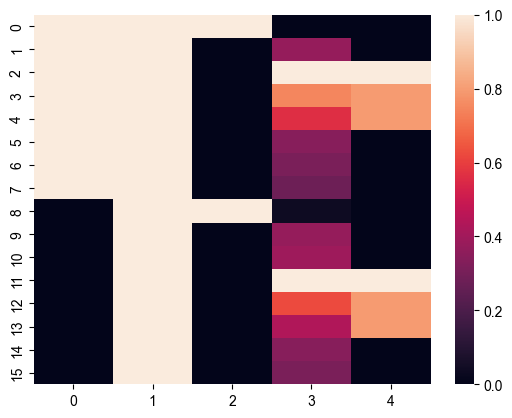

In [180]:
# set the metacolumns to use in the model
metacolumns = list(sub_conditions[1:]) + ['constant'] + ['Sex_d','BW','Age',]  # drop saline
# Select only continuous variables for scaling
continuous_vars = ['BW', 'Age']  # Modify as needed
scaler = MinMaxScaler()

# Predefine the link function
family = sm.families.NegativeBinomial()

for idx,acronym in enumerate(sub_merge_df.acronym.unique()):
    # don't run test if not enough subjects which seems to happen
    exog = sub_merge_df.loc[(sub_merge_df.acronym == acronym),metacolumns]
    exog[continuous_vars] = scaler.fit_transform(exog[continuous_vars])
    endog = sub_merge_df.loc[(sub_merge_df.acronym == acronym),'density']
    if idx == 0:
        sns.heatmap(np.array(exog.astype('float')))
        
    
    try:
        # run multiple GLM fits and comparison while dropping one of the variables

        glmfit = sm.GLM(endog, np.asarray(exog.astype('float64')),family=family,).fit()
        tglmfit = sm.GLM(endog, exog.astype('float64').drop(columns = sub_conditions[1:]),family=family,).fit() # Drop the conditions

        pvalue = chi2_model_comparison(glmfit,tglmfit) # calculate the pvalue from the chi2 likelihood test of the two models
        tdf = pd.DataFrame([pvalue],columns = ['Condition'])
        tdf['acronym'] = acronym
    except:
        # if doesn't run, save a nan
        # tdf = pd.DataFrame({'F':np.nan,'PR(>F)':np.nan,'acronym':acronym},index = [0])
        print(acronym)
        #tdf = pd.DataFrame(np.nan * np.zeros((1,len(metacolumns))),columns = metacolumns) # put pvalue of 1 with empty
        tdf = pd.DataFrame([np.nan],columns = ['Condition']) # put pvalue of 1 with empty
        tdf['acronym'] = acronym
        #print(acronym, " did not have enough subjects")

    if idx == 0:
        glm_stat_df = tdf
    else:
        glm_stat_df = pd.concat([glm_stat_df,tdf],axis=  0,).reset_index(drop = True)


In [181]:
# Write the glm stat data frame
condition = 'Acute_Morphine'
glm_stat_df = pd.merge(create_mask_for_region.get_subregions(atlasmeta, 8, return_original=True),glm_stat_df,left_on = 'acronym',right_on = 'acronym').\
    rename(columns = {'name':'Name','Condition':'pvalue'})
glm_stat_df.to_csv(os.path.join(analysis_resultpath,f'{figure_key}_{condition}_glm_stat_df_no_batch.csv'),index = False)
print(f'{figure_key}_{condition}_glm_stat_df_no_batch.csv')

Figure3_Acute_Morphine_glm_stat_df_no_batch.csv


In [197]:
import TreeBH
# you can run it with python too
input_csv = os.path.join(analysis_resultpath,f'{figure_key}_{condition}_glm_stat_df_no_batch.csv')
output_dir = os.path.join(analysis_resultpath)
TreeBH.run_tree_fdr_pipeline(
    input_csv,
    output_dir,
    pval_col="pvalue",
    save_key=f"{figure_key}_{condition}_glm_stat_df_no_batch",
    q_thresh=0.001,
    plot_html=True  # Set to False to skip HTML plot
)

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\scipy\stats\_stats_py.py:9322: RuntimeWarning:

divide by zero encountered in log



In [198]:
# read the results from the whole treeFDR f
TreeFDRF_df = pd.read_csv(os.path.join(analysis_resultpath,\
    f'TreeFDRF_pvalue_Figure2_C_glm_stat_df_no_batch.csv'),index_col = False)

# get the rejected acronyms
rejected_acronyms = TreeFDRF_df[(TreeFDRF_df.acronym.isin(curated_acronyms)) & (TreeFDRF_df.rejected == True)].acronym.values 
print(len(rejected_acronyms)," rejected acronyms")
print(rejected_acronyms)


85  rejected acronyms
['FrA' 'M1' 'M2' 'S1' 'S2' 'A24a (IL)' 'DI' 'GI' 'AuD' 'Au1' 'AuV' 'V2L'
 'V2M' 'V1' 'A24 (Cg)' 'A32 (PrL)' 'O' 'AI' 'A29-30 (RS)' 'PtA' 'TeA '
 'PRh' 'Ect' 'AO' 'TT' 'A25 (DP)' 'CA2' 'CA3' 'DLEnt' 'DIEnt' 'VIEnt'
 'MEnt' 'Post' 'PsS' 'DS' 'VeS' 'STr' 'Cl' 'La' 'CPre' 'CPr' 'CPi' 'CPc'
 'AcbC' 'AcbSh' 'IPAC' 'Tu' 'LS' 'Ce' 'ST' 'Sc' 'PIL' 'PP' 'MG' 'Po' 'PLi'
 'SG' 'AM' 'IAM' 'IAD' 'IMD' 'PoMn' 'MD' 'Sub' 'PVT' 'RE' 'Rh' 'CM' 'PC'
 'PrG' 'MBO' 'Com' 'VTA' 'PlPAG' 'MA3' 'PrEW' '4Sh' 'Pa4' 'VTg' 'SNC'
 'SPTg' 'IP' 'RLi ' 'CLi' 'DR']


In [199]:
# read the results from the treeFDR f
Acute_TreeFDRF_df = pd.read_csv(os.path.join(analysis_resultpath,f'TreeFDRF_pvalue_{figure_key}_{condition}_glm_stat_df_no_batch.csv'),index_col = False)


In [200]:
# add the cleaned acronym names to the TreeFDR dataframe
Acute_TreeFDRF_df = Acute_TreeFDRF_df.merge(atlas_df[['acronym','cleaned_acronym']],left_on = 'acronym',right_on = 'acronym')
#Acute_TreeFDRF_df = Acute_TreeFDRF_df.set_index('acronym')

In [201]:
# get the rejected acronyms and print
acute_rejected_acronyms = Acute_TreeFDRF_df[(Acute_TreeFDRF_df.acronym.isin(rejected_acronyms))&(Acute_TreeFDRF_df.rejected == True)].acronym.values
print(len(acute_rejected_acronyms), ' rejected acronyms')
#acute_rejected_acronyms


67  rejected acronyms


## Figure 3B

In [61]:
pannel_key = 'B'

In [63]:
# No cluster
# sort by pvalues
condition1 = 'Saline'
condition2 = 'Acute_Morphine'

In [72]:
# add pvalues to a dataframe
effect_size_df = sub_merge_df[['acronym','Condition','normalized_density']].groupby(['acronym','Condition']).mean().reset_index().pivot(index = 'acronym',columns = 'Condition',values = 'normalized_density')
from scipy.stats import ttest_ind
# for each unique acronym in sub_merge_df, conduct a ttest_ind using the Condition variable

for acronym in sub_merge_df.acronym.unique():
    #print(acronym)
    
    saline_array = sub_merge_df[(sub_merge_df.Condition == 'Saline') & (sub_merge_df.acronym == acronym)]['density'].values.astype('float')
    condition_array = sub_merge_df[(sub_merge_df.Condition == condition2) & (sub_merge_df.acronym == acronym)]['density'].values.astype('float')
    #
    s_,p_ = ttest_ind(saline_array, condition_array)
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_pvalue'] = p_
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_delta'] = np.mean(condition_array) - np.mean(saline_array)
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_signed_strength'] = -np.log10(p_) * np.sign(np.mean(condition_array) - np.mean(saline_array))

    # get decisions from treebh
    try:
        tree_qadj,tree_rej = Acute_TreeFDRF_df.loc[acronym,['q_adj','rejected']]
    except:
        tree_qadj,tree_rej = np.nan,np.nan
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_tree_rejected'] = tree_rej
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_tree_qadj'] = tree_qadj



In [161]:
# clean up the dataframes
from statsmodels.stats import multitest

# flatten the list
sorted_effect_size_df = effect_size_df.sort_values(by = [f'Saline_vs_{condition2}_pvalue']).loc[rejected_acronyms,[\
    f'Saline_vs_{condition2}_pvalue',f'Saline_vs_{condition2}_delta',f'Saline_vs_{condition2}_tree_rejected']]
    
#stats = 
stats,qvalues,__,__ = multitest.multipletests(sorted_effect_size_df[f'Saline_vs_{condition2}_pvalue'],method ='fdr_bh')
#teffect_size_df = pd.DataFrame(qvalues,index = sorted_effect_size_df.index,columns = [f'Saline_vs_{condition2}_qvalue'])
effect_size_df = effect_size_df.join(teffect_size_df)
sorted_acronyms_list = [sorted_effect_size_df[stats == f].sort_values(by = f'Saline_vs_{condition2}_delta',ascending = False).index\
    for f in [True,False]]
    

sorted_acronyms_list = [item for sublist in sorted_acronyms_list for item in sublist]
sorted_cleaned_acronyms_list = [atlas_df[atlas_df.acronym == f].cleaned_acronym.values[0] for f in sorted_acronyms_list]


In [162]:
effect_size_df.to_csv(os.path.join(analysis_resultpath,f'{figure_key}_effect_size_df.csv'),index = True)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_32544\625542881.py:4: UserWarning:

Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14



C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_32544\625542881.py:9: UserWarning:

Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_32544\625542881.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

4Sh_Acute_Morphine vs. 4Sh_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:3.549e-03 t=3.498e+00
IAD_Acute_Morphine vs. IAD_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:1.514e-04 t=5.136e+00
MD_Acute_Morphine vs. MD_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:1.281e-04 t=5.227e+00
CLi_Acute_Morphine vs. CLi_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:2.628e-06 t=7.560e+00
PC_Acute_Morphine vs. PC_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:6.264e-03 t=3.212e+00
A24a (IL)_Acute_Morphine vs. A24a (IL)_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:8.934e-04 t=4.198e+00
Ce_Acute_Morphine vs. Ce_Saline: t-test inde

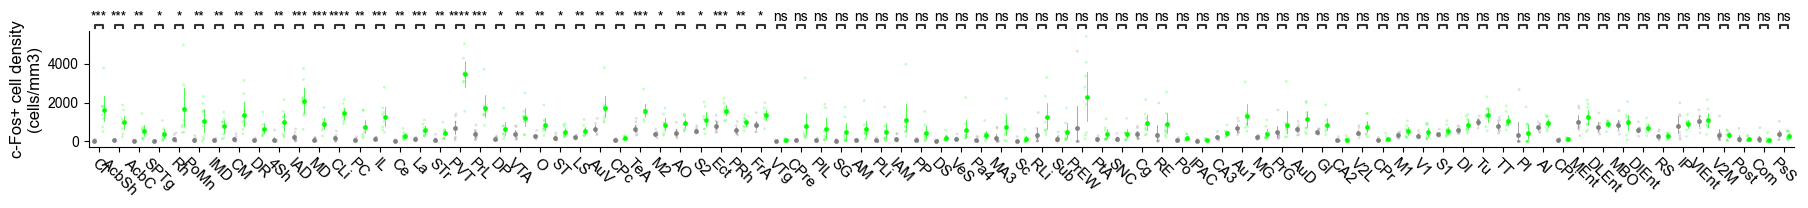

In [163]:

fig,axs = plt.subplots(1,1,figsize = (22,1.5))

sub_merge_df.Condition = sub_merge_df.Condition.astype('str')
sns.stripplot(data = sub_merge_df[(sub_merge_df.acronym.isin(rejected_acronyms))&(sub_merge_df.Condition.isin([condition1,condition2]))],
            hue = 'Condition',y = 'density',x = 'acronym',dodge = True,
            order = sorted_acronyms_list,\
            hue_order = [condition1,condition2],ax = axs,\
            palette = np.array(Condition_color)[[0,1]],alpha = 0.25,size = 2)
sns.pointplot(sub_merge_df[(sub_merge_df.acronym.isin(rejected_acronyms))&(sub_merge_df.Condition.isin(sub_conditions))],
            hue = 'Condition',y = 'density',x = 'acronym',order = sorted_acronyms_list,
            dodge = .5-.5/len(sorted_acronyms_list),\
        hue_order = [condition1,condition2],ax = axs,palette = np.array(Condition_color)[[0,1]],
markers="o", markersize=3, linestyle="none",linewidth = 0.5)  
sns.despine()
axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)
# remove legend
axs.get_legend().remove()
axs.set_xlabel('')
axs.set_ylabel('c-Fos+ cell density\n(cells/mm3)',fontsize = 12)
# add a horizontal line to separate the clusters
#borders = [0] + list(np.cumsum(nregions_list))
#[axs.axvline(border - 0.5,color = 'gray',lw = 2,ls = ':') for border in borders[1:-1]]


from statannotations.Annotator import Annotator
pairs = [((c,condition1),(c,condition2)) for c in sorted_acronyms_list]

annotator = Annotator(axs, pairs, data = sub_merge_df[(sub_merge_df.Condition.isin([condition1,condition2]))],
            hue = 'Condition',y = 'density',x = 'acronym',
            order = sorted_acronyms_list)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()


fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight')



In [164]:
# add pvalues to a dataframe
effect_size_df = sub_merge_df[['acronym','Condition','normalized_density']].groupby(['acronym','Condition']).mean().reset_index().pivot(index = 'acronym',columns = 'Condition',values = 'normalized_density')
from scipy.stats import ttest_ind
# for each unique acronym in sub_merge_df, conduct a ttest_ind using the Condition variable

for acronym in sub_merge_df.acronym.unique():
    #print(acronym)
    
    saline_array = sub_merge_df[(sub_merge_df.Condition == 'Saline') & (sub_merge_df.acronym == acronym)]['normalized_density'].values.astype('float')
    condition_array = sub_merge_df[(sub_merge_df.Condition == condition2) & (sub_merge_df.acronym == acronym)]['normalized_density'].values.astype('float')
    #
    s_,p_ = ttest_ind(saline_array, condition_array)
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_pvalue'] = p_
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_delta'] = np.mean(condition_array) - np.mean(saline_array)
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_signed_strength'] = -np.log10(p_) * np.sign(np.mean(condition_array) - np.mean(saline_array))

    # get decisions from treebh
    try:
        tree_qadj,tree_rej = Acute_TreeFDRF_df.loc[acronym,['q_adj','rejected']]
    except:
        tree_qadj,tree_rej = np.nan,np.nan
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_tree_rejected'] = tree_rej
    effect_size_df.loc[acronym,f'Saline_vs_{condition2}_tree_qadj'] = tree_qadj



In [177]:
# clean up the dataframes
from statsmodels.stats import multitest

# flatten the list
sorted_effect_size_df = effect_size_df.sort_values(by = [f'Saline_vs_{condition2}_pvalue']).loc[rejected_acronyms,[\
    f'Saline_vs_{condition2}_pvalue',f'Saline_vs_{condition2}_delta',f'Saline_vs_{condition2}_tree_rejected']]
    
stats = sorted_effect_size_df[f'Saline_vs_{condition2}_tree_rejected'].values

# Use pd.isna for nan, and direct comparison for True/False
true_mask = stats == True
false_mask = stats == False
nan_mask = pd.isna(stats)

true_acronyms = sorted_effect_size_df[true_mask].sort_values(by=f'Saline_vs_{condition2}_delta', ascending=False).index
false_acronyms = sorted_effect_size_df[false_mask].sort_values(by=f'Saline_vs_{condition2}_delta', ascending=False).index
nan_acronyms = sorted_effect_size_df[nan_mask].sort_values(by=f'Saline_vs_{condition2}_delta', ascending=False).index

sorted_acronyms_list = list(true_acronyms) + list(false_acronyms) + list(nan_acronyms)
sorted_cleaned_acronyms_list = [atlas_df[atlas_df.acronym == f].cleaned_acronym.values[0] for f in sorted_acronyms_list]
stats = sorted_effect_size_df.loc[sorted_acronyms_list,f'Saline_vs_{condition2}_tree_rejected'].values

In [178]:
stat_strings = []
for f in stats:
    if np.isnan(f):
        stat_strings.append('n.t.')
    elif f == False:
        stat_strings.append('n.d.')
    elif f:
        #print(f)
        stat_strings.append('*')

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_32544\1557872194.py:5: UserWarning:

Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_32544\1557872194.py:10: UserWarning:

Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_32544\1557872194.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



'from statannotations.Annotator import Annotator\npairs = [((c,condition1),(c,condition2)) for c in sorted_acronyms_list]\n\nannotator = Annotator(axs, pairs, data = sub_merge_df[(sub_merge_df.Condition.isin([condition1,condition2]))],\n            hue = \'Condition\',y = \'normalized_density\',x = \'acronym\',\n            order = sorted_acronyms_list,)\nannotator.configure(test=\'t-test_ind\', text_format=\'star\', loc=\'outside\',)\n#annotator.configure(comparisons_correction="BH", correction_format="replace")\nannotator.set_custom_annotations(stat_strings)\nannotator.apply_and_annotate()'

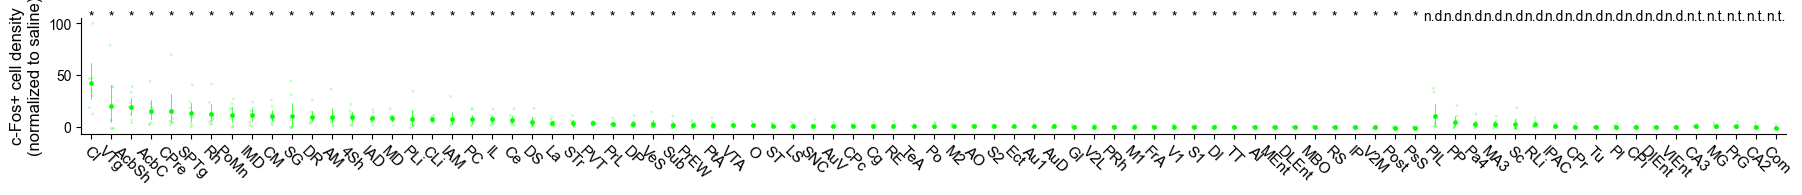

In [179]:

fig,axs = plt.subplots(1,1,figsize = (22,1.5))

sub_merge_df.Condition = sub_merge_df.Condition.astype('str')
#sub_merge_df = sub_merge_df.reset_index()
sns.stripplot(data = sub_merge_df[(sub_merge_df.acronym.isin(rejected_acronyms))&(sub_merge_df.Condition.isin([condition2]))],
            hue = 'Condition',y = 'normalized_density',x = 'acronym',dodge = False,
            order = sorted_acronyms_list,\
            hue_order = [condition1,condition2],ax = axs,\
            palette = np.array(Condition_color)[[0,1]],alpha = 0.25,size = 2)
sns.pointplot(sub_merge_df[(sub_merge_df.acronym.isin(rejected_acronyms))&(sub_merge_df.Condition.isin([condition2]))],
            hue = 'Condition',y = 'normalized_density',x = 'acronym',order = sorted_acronyms_list,
        hue_order = [condition1,condition2],ax = axs,palette = np.array(Condition_color)[[0,1]],
markers="o", markersize=3, linestyle="none",linewidth = 0.5)  
sns.despine()
axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)
# remove legend
axs.get_legend().remove()
axs.set_xlabel('')
axs.set_ylabel('c-Fos+ cell density\n(normalized to saline)',fontsize = 12)
# add a horizontal line to separate the clusters
#borders = [0] + list(np.cumsum(nregions_list))
#[axs.axvline(border - 0.5,color = 'gray',lw = 2,ls = ':') for border in borders[1:-1]]


for aidx, an in enumerate(stat_strings):
    axs.text(aidx , sub_merge_df[(sub_merge_df.acronym.isin(rejected_acronyms))&(sub_merge_df.Condition.isin([condition2]))].normalized_density.values.max()
             , an, ha='center', va='bottom')
'''from statannotations.Annotator import Annotator
pairs = [((c,condition1),(c,condition2)) for c in sorted_acronyms_list]

annotator = Annotator(axs, pairs, data = sub_merge_df[(sub_merge_df.Condition.isin([condition1,condition2]))],
            hue = 'Condition',y = 'normalized_density',x = 'acronym',
            order = sorted_acronyms_list,)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
#annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.set_custom_annotations(stat_strings)
annotator.apply_and_annotate()'''


#fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
#fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight')



## Figure 3C-H

In [28]:
pannel_key = 'C'

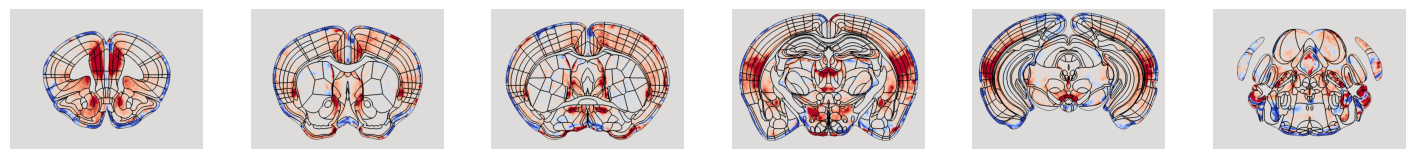

In [ ]:
# plot every 10 zplanes
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)

# pre selected zplanes
curated_zplanes = [84,104,117,153,186,220]

acute_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Acute_Morphine_betas.npy'))
saline_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Saline_betas.npy'))

# subtract the withdrawal heatmap from the chronic heatmap
theatmap = acute_heatmap - saline_heatmap

fig,axs = plt.subplots(1,len(curated_zplanes),figsize = (3*len(curated_zplanes),3),sharey = True)
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for idx,ax in enumerate(axs):
    formatted_idx = f"{curated_zplanes[idx]:04}" 
    
    __,overlayed_image = overlap_contour(theatmap,contour_img,\
    cmin =  -15, cmax = 15,\
    outputpath = None)
    ax.imshow(overlayed_image[curated_zplanes[idx],imy_slice,imx_slice])
    ax.axis('off')
    ax.set_title('')
    #ax.set_ylabel(condition,color = 'black')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 1024)

In [29]:
import numpy as np

def set_transparency(rgba_img, mask):
    """
    Applies a transparency mask to an existing RGBA image.

    Parameters:
    - rgba_img: np.ndarray of shape (H, W, 4), dtype uint8
        The input RGBA image.
    - mask: np.ndarray of shape (H, W), dtype bool
        Boolean mask where True means the pixel should be transparent.

    Returns:
    - np.ndarray of shape (H, W, 4), modified RGBA image.
    """
    if rgba_img.shape[-1] != 4:
        raise ValueError("Input image must be RGBA (shape must be H x W x 4).")
    if rgba_img.shape[:2] != mask.shape:
        raise ValueError("Mask shape must match image height and width.")

    # Copy to avoid modifying the original
    result = rgba_img.copy()
    result[mask, 3] = 0  # Set alpha to 0 (transparent) where mask is True
    return result


In [30]:
curated_zplanes = np.arange(75,225,2)
len(curated_zplanes)//5

15

In [ ]:
np.arange(75,225,6)

(25,)

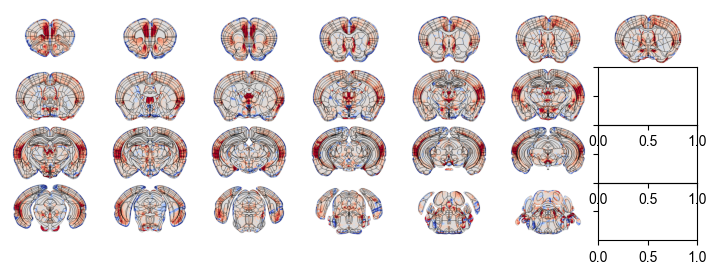

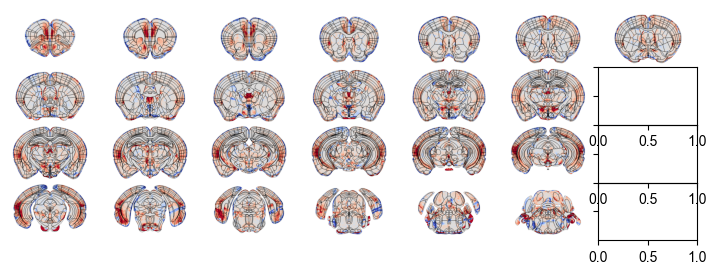

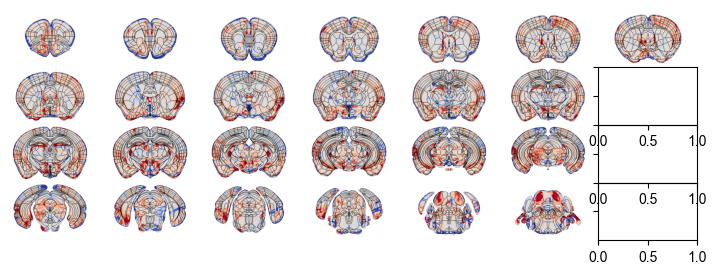

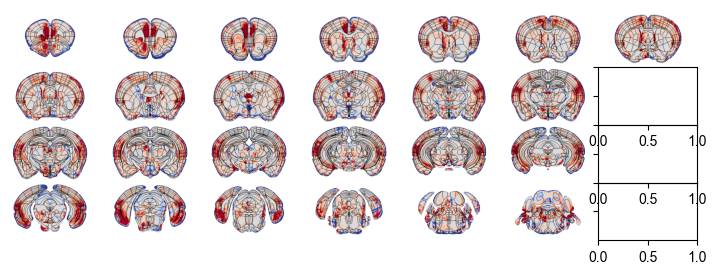

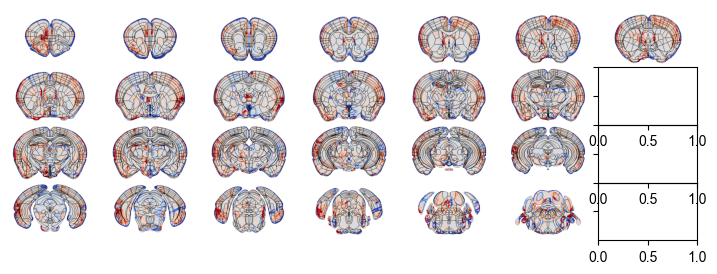

In [ ]:
# plot every .3 mm
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)

# pre selected zplanes
curated_zplanes = np.arange(79,229,6) # every .3 mm = 6 zplanes x 50 um 

for condition2 in Conditions[1:]:
    acute_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{condition2}_betas.npy'))
    #saline_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Saline_betas.npy'))

    # subtract the withdrawal heatmap from the chronic heatmap
    theatmap = acute_heatmap
    __,overlayed_image = overlap_contour(theatmap,contour_img,\
    cmin =  -15, cmax = 15,\
    outputpath = None)

    fig,axs = plt.subplots(len(curated_zplanes)//6,7,figsize = (3*3,len(curated_zplanes)//7),sharey = True)
    fig.subplots_adjust(wspace=0., hspace=0.)

    for idx,zplane in enumerate(curated_zplanes):
        if idx < 7:
            rows = 0
            columns = idx%7
        elif idx < 13:
            rows = 1
            columns = (idx + rows-1)%7
        elif idx < 19:
            rows = 2
            columns = (idx + rows-1)%7
        elif idx < 25:
            rows = 3
            columns = (idx + rows-1)%7

        ax = axs[rows,columns]
        formatted_idx = f"{zplane:04}" 
        trans_img = set_transparency(overlayed_image[zplane,:,:], (atlas_img==0)[zplane,:,:])
        ax.imshow(trans_img[imy_slice,imx_slice])
        ax.axis('off')
        ax.set_title('')
        #ax.set_ylabel(condition,color = 'black')
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition2}_03mm.png'),bbox_inches='tight',dpi = 1024)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition2}_03mm.pdf'),bbox_inches='tight',dpi = 1024)

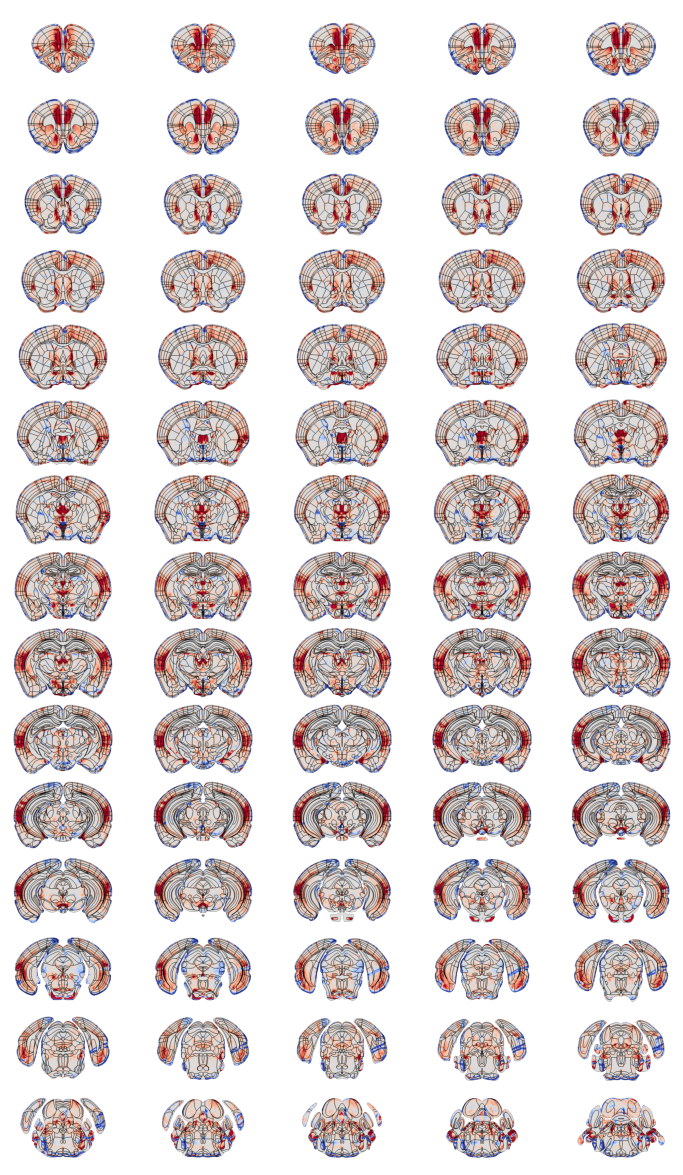

In [ ]:
# plot every 10 zplanes
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)

# pre selected zplanes
curated_zplanes = np.arange(75,225,2)

acute_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Acute_Morphine_betas.npy'))
saline_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Saline_betas.npy'))

# subtract the withdrawal heatmap from the chronic heatmap
theatmap = acute_heatmap
__,overlayed_image = overlap_contour(theatmap,contour_img,\
cmin =  -15, cmax = 15,\
outputpath = None)

fig,axs = plt.subplots(len(curated_zplanes)//5,5,figsize = (3*3,len(curated_zplanes)//5),sharey = True)
fig.subplots_adjust(wspace=0., hspace=0.)

for idx,zplane in enumerate(curated_zplanes):
    ax = axs.flatten()[idx]
    formatted_idx = f"{zplane:04}" 
    trans_img = set_transparency(overlayed_image[zplane,:,:], (atlas_img==0)[zplane,:,:])
    ax.imshow(trans_img[imy_slice,imx_slice])
    ax.axis('off')
    ax.set_title('')
    #ax.set_ylabel(condition,color = 'black')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_whole.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_whole.pdf'),bbox_inches='tight',dpi = 1024)

To match the hotspot/coldspot theory, examine the distribution of c-Fos signals in the following regions

OFC/Insula/NAc/VP/PBN/LH

## spatial analysis by subregions

### OFC

In [1]:
# target site can be experiment specific
target_site_acronym = 'O'
target_site_id = atlas_df.loc[atlas_df.acronym == target_site_acronym,'id'].values[0]
target_site_subids = create_mask_for_region.get_subregions(atlas_df,target_site_id,return_original=True)['id'].values


NameError: name 'atlas_df' is not defined

In [2]:
# collect all the z positions where there is the target site
zs = np.array([])
for ID in target_site_subids:
    z_,y_,x_ = np.where(atlas_img == ID)
    zs = np.concatenate([zs,z_])
# find the center of mass of the OFC
z_unique = np.unique(zs).astype('uint16')
z_center = int(np.mean(zs))


NameError: name 'np' is not defined

In [136]:
# subset to target region
xslice = slice(325,325+120)
yslice = slice(160,160+120)

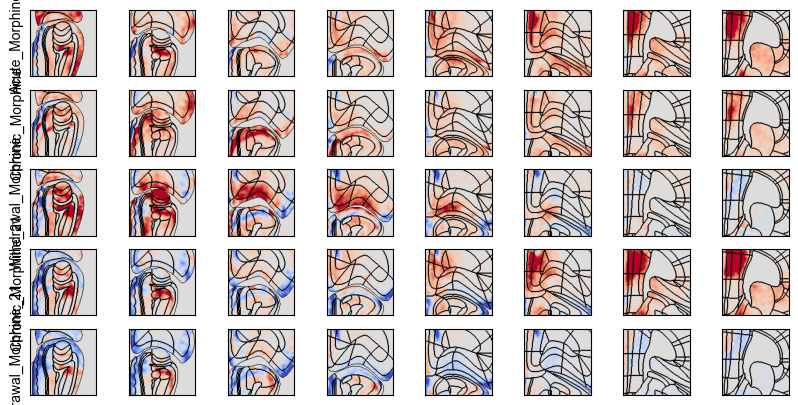

In [138]:
# plot the spatial distribution of starter cells for each subject

fig, axs = plt.subplots(len(Conditions)-1, len(z_unique[::5]), figsize=(len(z_unique[::5])*1.25, len(Conditions)-1), sharex=True,sharey = True)


for cidx, condition in enumerate(Conditions[1:]):

    theatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{condition}_betas.npy'))
    #theatmap = np.mean(np.array([heatmap_dict[condition][subject] for subject in heatmap_dict[condition].keys()]),axis = 0)
    __,overlayed_image = overlap_contour(theatmap,contour_img,\
        cmin =  -15, cmax = 15,\
        outputpath = None)
    for idx, curated_zplane in enumerate(z_unique[::5]):
        ax = axs[cidx, idx]
        ax.imshow(overlayed_image[curated_zplane,yslice,xslice],cmap = 'viridis')
        ax.set_xticks([])  # Remove x ticks
        ax.set_yticks([])  # Remove y ticks
        #ax.axis('off')
        if idx == 0:
            ax.set_ylabel(condition, color='black', )
        else:
            ax.set_ylabel('', color='black',)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.png'),bbox_inches='tight',dpi = 512)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.pdf'),bbox_inches='tight',dpi = 512)

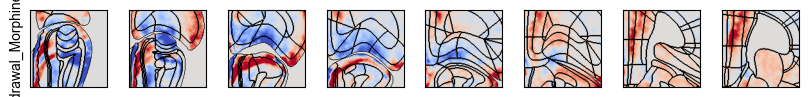

In [ ]:
# plot the spatial distribution of starter cells for each subject

fig, axs = plt.subplots(1, len(z_unique[::5]), figsize=(len(z_unique[::5])*1.25, 1), sharex=True,sharey = True)



chronic_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Chronic_Morphine_betas.npy'))
withdrawal_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Withdrawal_Morphine_betas.npy'))
theatmap = chronic_heatmap - withdrawal_heatmap
#theatmap = np.mean(np.array([heatmap_dict[condition][subject] for subject in heatmap_dict[condition].keys()]),axis = 0)
__,overlayed_image = overlap_contour(theatmap,contour_img,\
    cmin =  -15, cmax = 15,\
    outputpath = None)
for idx, curated_zplane in enumerate(z_unique[::5]):
    ax = axs[idx]
    ax.imshow(overlayed_image[curated_zplane,yslice,xslice],cmap = 'viridis')
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove y ticks
    #ax.axis('off')
    if idx == 0:
        ax.set_ylabel('delta betacoef', color='black', )
    else:
        ax.set_ylabel('', color='black',)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.png'),bbox_inches='tight',dpi = 512)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.pdf'),bbox_inches='tight',dpi = 512)

### VP

In [151]:
# target site can be experiment specific
target_site_acronym = 'VeP'
target_site_id = atlas_df.loc[atlas_df.acronym == target_site_acronym,'id'].values[0]
target_site_subids = create_mask_for_region.get_subregions(atlas_df,target_site_id,return_original=True)['id'].values


In [152]:
# collect all the z positions where there is the target site
zs = np.array([])
for ID in target_site_subids:
    z_,y_,x_ = np.where(atlas_img == ID)
    zs = np.concatenate([zs,z_])
# find the center of mass of the OFC
z_unique = np.unique(zs).astype('uint16')
z_center = int(np.mean(zs))


In [153]:
# subset to target region
xslice = slice(325,325+120)
yslice = slice(255,255+120)

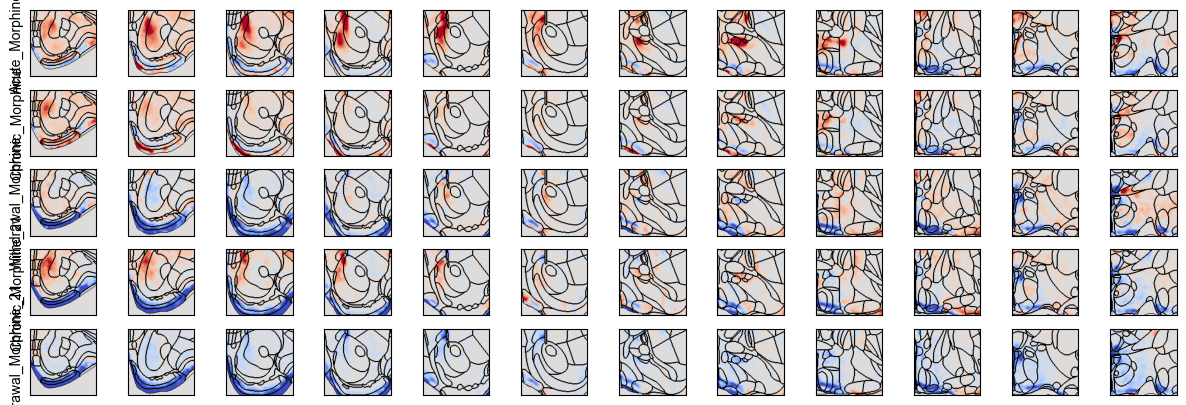

In [154]:
# plot the spatial distribution of starter cells for each subject

fig, axs = plt.subplots(len(Conditions)-1, len(z_unique[::5]), figsize=(len(z_unique[::5])*1.25, len(Conditions)-1), sharex=True,sharey = True)


for cidx, condition in enumerate(Conditions[1:]):

    theatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{condition}_betas.npy'))
    #theatmap = np.mean(np.array([heatmap_dict[condition][subject] for subject in heatmap_dict[condition].keys()]),axis = 0)
    __,overlayed_image = overlap_contour(theatmap,contour_img,\
        cmin =  -15, cmax = 15,\
        outputpath = None)
    for idx, curated_zplane in enumerate(z_unique[::5]):
        ax = axs[cidx, idx]
        ax.imshow(overlayed_image[curated_zplane,yslice,xslice],cmap = 'viridis')
        ax.set_xticks([])  # Remove x ticks
        ax.set_yticks([])  # Remove y ticks
        #ax.axis('off')
        if idx == 0:
            ax.set_ylabel(condition, color='black', )
        else:
            ax.set_ylabel('', color='black',)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.png'),bbox_inches='tight',dpi = 512)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.pdf'),bbox_inches='tight',dpi = 512)

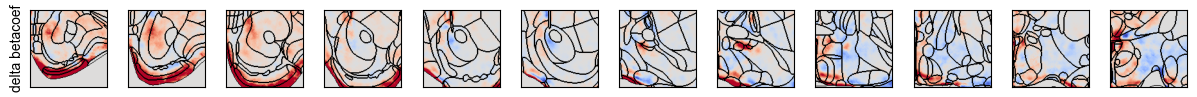

In [155]:
# plot the spatial distribution of starter cells for each subject

fig, axs = plt.subplots(1, len(z_unique[::5]), figsize=(len(z_unique[::5])*1.25, 1), sharex=True,sharey = True)



chronic_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Chronic_Morphine_betas.npy'))
withdrawal_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Withdrawal_Morphine_betas.npy'))
theatmap = chronic_heatmap - withdrawal_heatmap
#theatmap = np.mean(np.array([heatmap_dict[condition][subject] for subject in heatmap_dict[condition].keys()]),axis = 0)
__,overlayed_image = overlap_contour(theatmap,contour_img,\
    cmin =  -15, cmax = 15,\
    outputpath = None)
for idx, curated_zplane in enumerate(z_unique[::5]):
    ax = axs[idx]
    ax.imshow(overlayed_image[curated_zplane,yslice,xslice],cmap = 'viridis')
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove y ticks
    #ax.axis('off')
    if idx == 0:
        ax.set_ylabel('delta betacoef', color='black', )
    else:
        ax.set_ylabel('', color='black',)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.png'),bbox_inches='tight',dpi = 512)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.pdf'),bbox_inches='tight',dpi = 512)

### Insular

In [163]:
# target site can be experiment specific
target_site_acronym = 'Insular'
# for this case the target site is the insular cortex and is defined by acronym AI, GI and DI
# get the ids for these regions and combine them as target_site_ids, 
target_site_ids = atlas_df.loc[atlas_df.acronym.isin(['AI','GI','DI']),'id'].values
# then get target_site_subids for all sub regions of target_site_ids

target_site_subids = [create_mask_for_region.get_subregions(atlas_df,target_site_id,return_original=True)['id'].values for target_site_id in target_site_ids]


In [164]:
# flatten target_site_subids, a list, into one np array
target_site_subids = np.concatenate(target_site_subids).astype('int')

In [166]:
# collect all the z positions where there is the target site
zs = np.array([])
for ID in target_site_subids:
    z_,y_,x_ = np.where(atlas_img == ID)
    zs = np.concatenate([zs,z_])
# find the center of mass of the OFC
z_unique = np.unique(zs).astype('uint16')
z_center = int(np.mean(zs))


In [175]:
atlas_img.shape

(300, 450, 650)

In [176]:
# subset to target region
# make the slice move along the z position

def get_slice(z,target_site_subids,hemi = 'left'):
    ys = np.array([])
    xs = np.array([])
    if hemi == 'left':
        hemi_slice = slice(0,atlas_img.shape[2]//2)
    else:
        hemi_slice = slice(atlas_img.shape[2]//2,atlas_img.shape[2])
    for ID in target_site_subids:
        y_,x_ = np.where(atlas_img[z,:,hemi_slice] == ID)
        xs = np.concatenate([xs,x_])
        ys = np.concatenate([ys,y_])
    # find the center of mass of the OFC
    y_center = int(np.mean(ys))
    x_center = int(np.mean(xs))
    # set the slice to the center of mass of the target site
    yslice = slice(y_center-60,y_center+60)
    xslice = slice(x_center-60,x_center+60)
    return yslice,xslice

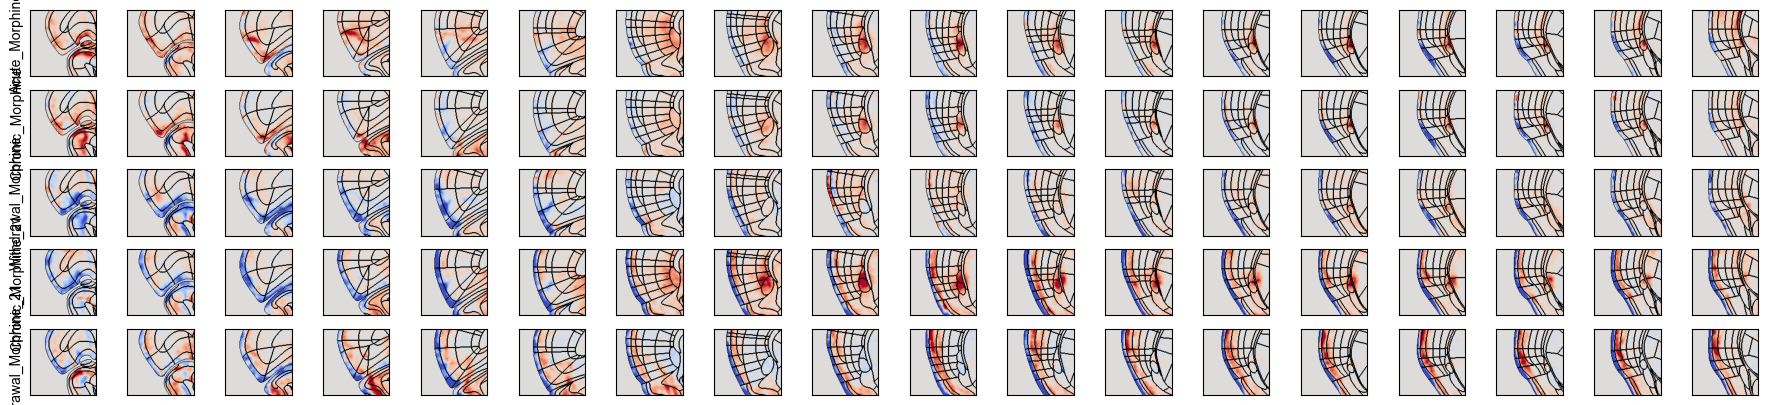

In [177]:
# plot the spatial distribution of starter cells for each subject

fig, axs = plt.subplots(len(Conditions)-1, len(z_unique[::5]), figsize=(len(z_unique[::5])*1.25, len(Conditions)-1), sharex=True,sharey = True)


for cidx, condition in enumerate(Conditions[1:]):

    theatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{condition}_betas.npy'))
    #theatmap = np.mean(np.array([heatmap_dict[condition][subject] for subject in heatmap_dict[condition].keys()]),axis = 0)
    __,overlayed_image = overlap_contour(theatmap,contour_img,\
        cmin =  -15, cmax = 15,\
        outputpath = None)
    for idx, curated_zplane in enumerate(z_unique[::5]):
        yslice,xslice = get_slice(curated_zplane,target_site_subids)
        ax = axs[cidx, idx]
        ax.imshow(overlayed_image[curated_zplane,yslice,xslice],cmap = 'viridis')
        ax.set_xticks([])  # Remove x ticks
        ax.set_yticks([])  # Remove y ticks
        #ax.axis('off')
        if idx == 0:
            ax.set_ylabel(condition, color='black', )
        else:
            ax.set_ylabel('', color='black',)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.png'),bbox_inches='tight',dpi = 512)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.pdf'),bbox_inches='tight',dpi = 512)

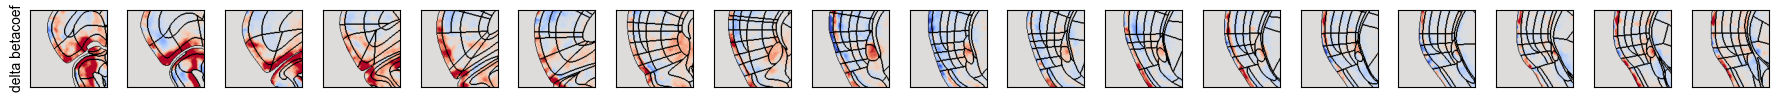

In [178]:
# plot the spatial distribution of starter cells for each subject

fig, axs = plt.subplots(1, len(z_unique[::5]), figsize=(len(z_unique[::5])*1.25, 1), sharex=True,sharey = True)



chronic_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Chronic_Morphine_betas.npy'))
withdrawal_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Withdrawal_Morphine_betas.npy'))
theatmap = chronic_heatmap - withdrawal_heatmap
#theatmap = np.mean(np.array([heatmap_dict[condition][subject] for subject in heatmap_dict[condition].keys()]),axis = 0)
__,overlayed_image = overlap_contour(theatmap,contour_img,\
    cmin =  -15, cmax = 15,\
    outputpath = None)
for idx, curated_zplane in enumerate(z_unique[::5]):
    yslice,xslice = get_slice(curated_zplane,target_site_subids)
    ax = axs[idx]
    ax.imshow(overlayed_image[curated_zplane,yslice,xslice],cmap = 'viridis')
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove y ticks
    #ax.axis('off')
    if idx == 0:
        ax.set_ylabel('delta betacoef', color='black', )
    else:
        ax.set_ylabel('', color='black',)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.png'),bbox_inches='tight',dpi = 512)
#fig.savefig(os.path.join(analysis_figurepath,f'Conditions_{target_site_acronym}_betacoef_spatial_distibution.pdf'),bbox_inches='tight',dpi = 512)